Projeto 2: Dinâmicas de Opinião em Redes Sociais
Descrição: Os alunos criarão um modelo para explorar a formação e evolução de opiniões em uma rede social fictícia. Cada agente terá uma opinião inicial e pode alterá-la com base nas interações com outros agentes.

Objetivos:

Explorar o efeito de diferentes topologias de rede (como redes em escala livre versus redes aleatórias).
Estudar a influência de agentes "influenciadores" com grande número de conexões.
Observar fenômenos como a polarização de opiniões ou a formação de consensos.


TODO


*   Melhorar condição para remover uma conexão (edge) entre dois agentes (Unfollow)
*   Melhorar condição para mudar a opinião do agente.
*   Adicionar lógica para criar uma nova conexão entre dois agentes.
*   Melhorar a forma que a quantidade de conexões de cada agente é inicializada, tanto influencer quanto regulares.
*   Implementar a criação da rede aleatoria.
*   Adicionar como parametro a possibilidade de escolher entre a rede scale-free e a aleatoria.
*   Melhorar mensagens. Qual a melhor forma de enviar a persuasão? Quais perfomativas da para utilizar?
*   Melhorar a representação e relação entre as opiniões. A forma atual é a melhor para representar a dificuldade de mudar para opiniões opostas?
*  Quais outros grupos poderiam ser criados além de usuarios regulares e influencers? qual caracteristicas eles teriam?
*  Melhorar a forma como a resistencia e a persuasão são inicializados para cada grupo. Faz sentido o influencer ter uma maior resistência?
*  Como representar uma negociação no processo de mudança de opinião?
*  Como podemos representar Fake News? Ou a criação de uma opinião nova na rede?
*  Como identificar cada grupo na animação?
*  Quais outros conceitos abordados na aula podem ser implementados?
* Como fazer que os influencer mudem menos de opinião?









In [1]:
# !pip install agentpy

In [2]:

import agentpy as ap
import numpy as np


class Pessoa(ap.Agent):
    def setup(self):
        self.opinion = self.model.random.choice(list(self.model.opinion_g.nodes))
        self.role = None
        self.interaction_history = {}
        self.record('opinion', self.opinion)

    def setup_roles(self):
        if self.role == "regular":
            self.resistance = self.model.random.random()
            self.persuasion = self.model.random.random()
        elif self.role == "influencer":
            self.resistance = self.model.random.uniform(0.8, 1)
            self.persuasion = self.model.random.uniform(0.8, 1)

    def send_message(self, receiver, performative, content):
          message = {
              'performative': performative,
              'sender': self,
              'receiver': receiver,
              'content': content
          }
          receiver.receive_message(message)

    def receive_message(self, message):
        if message['performative'] == 'inform':
          self.process_message(message)

    def process_message(self, message):
        changed_opinion = False
        other_opinion, other_persuasion = message["content"].split(",")
        sender = message["sender"]

        other_persuasion = float(other_persuasion)

        if self.opinion != other_opinion:

            if (self.model.random.random()) <= ((1 - self.resistance) * (1 + (other_persuasion - self.model.opinion_difficulty(self.opinion, other_opinion)))):
                    self.opinion = other_opinion
                    changed_opinion  = True
                    self.record('opinion', self.opinion)


        int_factor = self.get_interaction_factor(self.model.opinion_difficulty(self.opinion, other_opinion), sender, changed_opinion)

        # #Unfollow
        r = self.model.nprandom.power(5)
        int_qty = self.model.t #Número de iterações

        # A ideia aq é fazer com que a probabilidade de unfollow seja baixa e esteja relacionado as iterações com agentes com opiniões divergentes
        #Muitas iterações com um agente com uma opinião contraria com uma persuasão abaixo da resistencia do receptor aumenta a probabilidade de unfollow
        c = ((int_factor/ int_qty) - (other_persuasion - self.resistance))
        if r <= c:
            # print(f"n - {r},{c}")
            self.model.add_edge_to_remove((self.position, sender.position))



    def get_interaction_factor(self, opinion_diff, agent, changed_opinion):
        if agent.position not in self.interaction_history or changed_opinion:
            self.interaction_history[agent.position] = 0

        #Mais interações devem aumentar a probabilidade de deixar de seguir se as opiniões divergem
        self.interaction_history[agent.position] += opinion_diff

        return self.interaction_history[agent.position]


    def update_vizinhos(self):
        self.vizinhos = len(list(self.model.network.neighbors(self)))


In [3]:
import math

import networkx as nx


class SocialModel(ap.Model):
    def setup(self):
        self.opinion_g = self.p.opinion_g
        self.agents = ap.AgentList(self,  self.p.population, Pessoa)
        self.__create_groups()
        self.network = self.agents.network = self.__created_scale_free_network()
        self.agents.setup_roles()
        self.edges_to_remove = []


    def step(self):
        self.edges_to_remove = []
        # print(self.t)

        for agent in self.agents:
            if(agent.vizinhos > 0):
                chosen_neigh = self.network.neighbors(agent).to_list().random(self.model.random.randint(1,agent.vizinhos))
                for other_agent in chosen_neigh:
                    agent.send_message(receiver = other_agent, performative = "inform", content = f"{agent.opinion},{agent.persuasion}")

        print(f"removed edges - {self.edges_to_remove}")
        self.network.graph.remove_edges_from(self.edges_to_remove)
        self.agents.update_vizinhos()

        edges_to_add = []

        for agent1_pos, info in nx.shortest_path_length(self.network.graph):

          agent = [agent for agent in self.agents if agent.position == agent1_pos][0]

          for agent_2_pos, dist in info.items():
            if agent1_pos != agent_2_pos and dist != 1:
              other_agent =  [agent for agent in self.agents if agent.position == agent_2_pos][0]
              r = self.model.nprandom.power(5)
              c = ( 1 - self.model.opinion_difficulty(agent.opinion, other_agent.opinion)) / dist
            #   print(f"random - {r}, diff - {self.model.opinion_difficulty(agent.opinion, other_agent.opinion)}, dist - {dist}, calc - {c} | {agent}, {other_agent}")
              if r < c:
                edges_to_add.append((agent.position, other_agent.position))

        print(f"add edges - {edges_to_add}")
        self.network.graph.add_edges_from(edges_to_add)
        self.agents.update_vizinhos()


    def __create_groups(self):
        self.influencer_group = ap.AgentList(self)  # Cria uma nova lista de agentes para o grupo 1
        self.regular_group = ap.AgentList(self)  # Cria uma nova lista de agentes para o grupo 2

        inf_qty = int(self.p.influencer_per * self.p.population)
        inf_agents = self.agents.random(inf_qty)

        self.influencer_group.extend(inf_agents)

        reg_agents = [agent for agent in self.agents if agent not in self.influencer_group]
        self.regular_group.extend(reg_agents)

        self.influencer_group.role = "influencer"
        self.regular_group.role = "regular"


    def __created_scale_free_network(self):
        degrees = []

        for agent in self.agents:
            if agent in self.influencer_group:
                degrees.append(int(self.p.population / 3))
            elif agent in self.regular_group:
                degrees.append(np.random.randint(1, 5))

        if sum(degrees) % 2 != 0:
            degrees[np.random.randint(0, self.p.population)] += 1

        graph = nx.configuration_model(degrees)
        graph = nx.Graph(graph)
        graph.remove_edges_from(nx.selfloop_edges(graph))

        network = ap.Network(self, graph)
        network.add_agents(self.agents, network.nodes)

        for agent in self.agents:
            agent.vizinhos = len(list(network.neighbors(agent)))
            agent.position = network.positions[agent]

        return network


    def __create_random_network(self):
        graph = nx.erdos_renyi_graph(
            self.p.population,
            0.2,
            42
        )

        return ap.Network(self, graph)


    def opinion_difficulty(self, opinion_1, opinion_2):
        difficulty = nx.dijkstra_path_length(self.opinion_g, opinion_1, opinion_2)

        return difficulty

    def add_edge_to_remove(self, edge):
        self.edges_to_remove.append(edge)



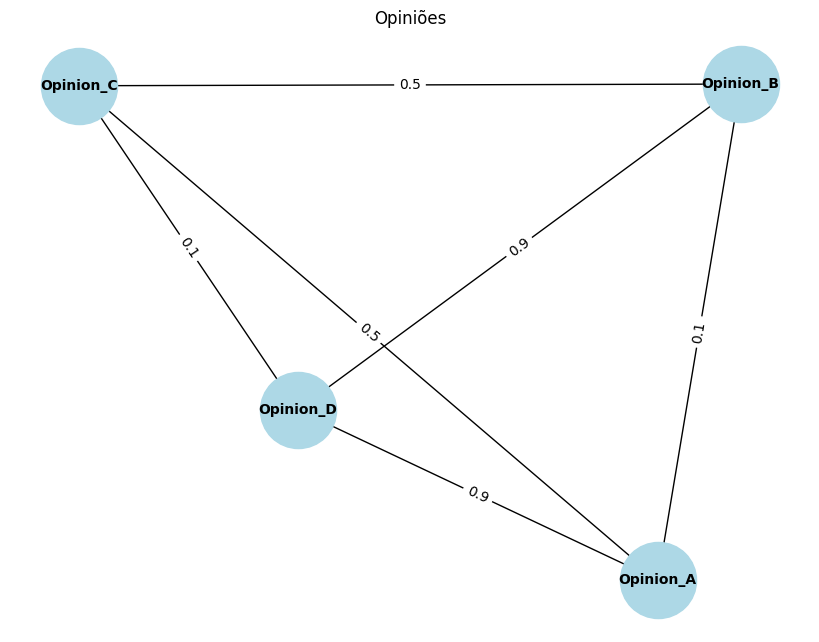

In [4]:
import random

import matplotlib.pyplot as plt

opinions = ['Opinion_A', 'Opinion_B', 'Opinion_C', 'Opinion_D']

weights = {
    ('Opinion_A', 'Opinion_B'): 0.1,  # low difficulty
    ('Opinion_B', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_A', 'Opinion_D'): 0.9,  # high difficulty
    ('Opinion_D', 'Opinion_C'): 0.1,  # low difficulty
    ('Opinion_A', 'Opinion_C'): 0.5,  # moderate difficulty
    ('Opinion_B', 'Opinion_D'): 0.9   # moderate difficulty
}


opinion_g = nx.Graph()
opinion_g.add_nodes_from(opinions)


for (op1, op2), weight in weights.items():
    opinion_g.add_edge(op1, op2, weight=weight)

pos = nx.spring_layout(opinion_g)
labels = nx.get_edge_attributes(opinion_g, 'weight')


plt.figure(figsize=(8, 6))
nx.draw(opinion_g, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold')
nx.draw_networkx_edge_labels(opinion_g, pos, edge_labels=labels)
plt.title("Opiniões")
plt.show()

In [5]:
parameters = {
    'population': 50,
    'steps': 20,
    'influencer_per': 0.05,
    'opinion_g' : opinion_g
}

In [6]:
model = SocialModel(parameters)

In [7]:
results = model.run()

removed edges - [(AgentNode (0), AgentNode (4)), (AgentNode (48), AgentNode (7)), (AgentNode (18), AgentNode (8)), (AgentNode (9), AgentNode (19)), (AgentNode (14), AgentNode (21)), (AgentNode (9), AgentNode (27)), (AgentNode (14), AgentNode (34)), (AgentNode (35), AgentNode (36)), (AgentNode (30), AgentNode (43)), (AgentNode (28), AgentNode (43)), (AgentNode (9), AgentNode (43)), (AgentNode (7), AgentNode (48))]
add edges - [(AgentNode (7), AgentNode (18)), (AgentNode (11), AgentNode (47)), (AgentNode (11), AgentNode (37)), (AgentNode (12), AgentNode (40)), (AgentNode (13), AgentNode (32)), (AgentNode (13), AgentNode (41)), (AgentNode (39), AgentNode (6)), (AgentNode (40), AgentNode (10))]
Completed: 1 stepsremoved edges - [(AgentNode (41), AgentNode (20)), (AgentNode (23), AgentNode (22)), (AgentNode (20), AgentNode (41)), (AgentNode (9), AgentNode (41)), (AgentNode (41), AgentNode (44))]
add edges - [(AgentNode (9), AgentNode (41)), (AgentNode (10), AgentNode (19)), (AgentNode (11),

In [8]:
import re

import matplotlib.pyplot as plt


def animation_plot(m, ax):

    ax.set_title("Animacao")

    # Plot network on second axis
    color_dict = {'Opinion_A':'b', 'Opinion_B':'r', 'Opinion_C':'g','Opinion_D':'y'}
    colors = [color_dict[c] for c in m.agents.opinion]

    labels = {}
    for agent, _ in m.network.graph.nodes(data=True):
        labels[agent] = re.search('\d+',str(agent)).group(0)

    sizes = [s * 10 for s in m.agents.vizinhos]
    nx.draw_kamada_kawai(m.network.graph, node_color=colors, node_size=sizes, ax=ax,with_labels = True, labels = labels,font_color="purple", horizontalalignment= "right")
    # nx.draw_circular(m.network.graph, node_color=colors, node_size=sizes, ax=ax)

fig, axs = plt.subplots(1, 1, figsize=(7, 7))
animation = ap.animate(SocialModel(parameters), fig, axs, animation_plot)

In [9]:
import IPython

IPython.display.HTML(animation.to_jshtml())

removed edges - [(AgentNode (38), AgentNode (0)), (AgentNode (38), AgentNode (10)), (AgentNode (38), AgentNode (17)), (AgentNode (38), AgentNode (18)), (AgentNode (31), AgentNode (19)), (AgentNode (10), AgentNode (20)), (AgentNode (10), AgentNode (24)), (AgentNode (9), AgentNode (30)), (AgentNode (12), AgentNode (41)), (AgentNode (12), AgentNode (46)), (AgentNode (16), AgentNode (47))]
add edges - [(AgentNode (4), AgentNode (13)), (AgentNode (6), AgentNode (14)), (AgentNode (7), AgentNode (48)), (AgentNode (28), AgentNode (7)), (AgentNode (34), AgentNode (2)), (AgentNode (44), AgentNode (22)), (AgentNode (46), AgentNode (27))]
removed edges - [(AgentNode (7), AgentNode (2)), (AgentNode (21), AgentNode (19)), (AgentNode (11), AgentNode (29))]
add edges - [(AgentNode (1), AgentNode (33)), (AgentNode (8), AgentNode (5)), (AgentNode (26), AgentNode (16)), (AgentNode (28), AgentNode (31)), (AgentNode (33), AgentNode (35)), (AgentNode (43), AgentNode (15))]
removed edges - [(AgentNode (5), A